In [119]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder

plt.rc("font", family="Malgun Gothic")
matplotlib.rcParams["axes.unicode_minus"] = False

In [341]:
train = pd.read_csv('open/train.csv').drop(columns=['ID'])
test = pd.read_csv('open/test.csv').drop(columns=['ID'])

In [342]:
drop_cols = [
    # unqiue value <= 1
    "착상 전 유전 검사 사용 여부",
    "난자 채취 경과일", 
    "PGS 시술 여부", 
    "PGD 시술 여부", 
    "불임 원인 - 여성 요인",
    
    # NaN 비율 99% 이상
    '난자 해동 경과일', 
    '불임 원인 - 정자 면역학적 요인', 
    '불임 원인 - 자궁경부 문제',
    
    # 정보가 거의 없는 변수
    '배란 유도 유형',
    
    # Feature Importance == 0
    "불임 원인 - 정자 형태",
    
    
]

train = train.drop(columns=drop_cols)
test = test.drop(columns=drop_cols)

In [343]:
def process_treatment_type(value):
    """
    특정 시술 유형을 정리하고, 단일 시술과 복합 시술로 구분하며, 데이터가 적은 시술을 'Unknown'으로 변경하는 함수.
    """

    # NaN 처리
    if pd.isna(value): 
        return "Unknown"

    # 공백 제거 및 기본 정리
    value = value.strip().replace(" ", "")

    # 중복 표기 정리 (예: ICSI:ICSI -> ICSI)
    replacements = {
        "ICSI:ICSI": "ICSI",
        "IVF:IVF": "IVF",
        "IVF:ICSI": "ICSI:IVF",  # ICSI:IVF로 통일
        "ICSI/BLASTOCYST:IVF/BLASTOCYST": "ICSI/BLASTOCYST",
        "ICSI/BLASTOCYST :IVF/BLASTOCYST": "ICSI/BLASTOCYST",
        "ICSI/BLASTOCYST:ICSI": "ICSI/BLASTOCYST",
        "IUI:ICI": "IUI"
    }
    for key, val in replacements.items():
        value = value.replace(key, val)

    # Unknown 포함된 경우 정리
    if "Unknown" in value:
        value = value.replace(":Unknown", "").replace("/Unknown", "")

    # 특정 시술 유형을 단일 시술과 복합 시술로 구분
    if ("/" in value) or (":" in value):  
        return "복합 시술"

    # 데이터 개수가 적은 특정 시술 유형을 'Unknown'으로 변경
    low_count_treatments = {"FER", "GIFT", "GenericDI", "ICI", "IVI"}
    if value in low_count_treatments:
        return "Unknown"

    return value

In [344]:
import re 

def df_preprocessing(df):
    """ Preprocessing of the dataframe"""
    new_df = df.copy(deep=True)
    
    # 횟수 변수 : 성능 동일
    count_columns = [
        "총 시술 횟수", "IVF 시술 횟수", "DI 시술 횟수", "클리닉 내 총 시술 횟수",
        "총 임신 횟수", "IVF 임신 횟수", "DI 임신 횟수",
        "총 출산 횟수", "IVF 출산 횟수", "DI 출산 횟수"]
    for col in count_columns:
        new_df[col] = new_df[col].replace("6회 이상", "6").str.replace("회", "").astype(int)
        
        
    # 시술 당시 나이 변환 (중간값 사용) : 나이가 어릴 수록 성공률 높아지기에 이를 수치변수로 변환
    age_map_surgery = {
        "만18-34세": 26,
        "만35-37세": 36,
        "만38-39세": 38,
        "만40-42세": 41,
        "만43-44세": 43,
        "만45-50세": 47,
        # "알 수 없음": -1
        "알 수 없음": 36 # median으로 채우기
    }
    new_df["시술 당시 나이"] = new_df["시술 당시 나이"].map(age_map_surgery)
    
    # 난자 기증자 나이 변환 
    # age_map_donor = {
    #     "알 수 없음": -1,
    #     "만20세 이하": 18,
    #     "만21-25세": 23,
    #     "만26-30세": 28,
    #     "만31-35세": 33
    # }
    # new_df["난자 기증자 나이"] = new_df["난자 기증자 나이"].map(age_map_donor)


    # 특정 시술 유형 
    new_df["특정 시술 유형"] = new_df["특정 시술 유형"].apply(process_treatment_type)
    
    # 클리닉 외 총 시술 횟수 
    new_df['클리닉 외 총 시술 횟수'] = new_df['총 시술 횟수'] - new_df['클리닉 내 총 시술 횟수']
    
    # 배아 사용률 (Fold 5 빼고 모두 상승)
    new_df["배아 사용률"] = new_df["이식된 배아 수"] / (new_df["총 생성 배아 수"] + 1)
    
    # 미세 주입률 
    new_df["미세주입률"] = new_df["미세주입된 난자 수"] / (new_df["총 생성 배아 수"] + 1)
    
    new_df["시술 성공률"] = new_df["총 임신 횟수"] / (new_df["총 시술 횟수"] + 1)  
    new_df["IVF 성공률"] = new_df["IVF 임신 횟수"] / (new_df["IVF 시술 횟수"] + 1)  
    new_df["DI 성공률"] = new_df["DI 임신 횟수"] / (new_df["DI 시술 횟수"] + 1) 
    
    
    new_df["배아 보존율"] = new_df["저장된 배아 수"] / (new_df["총 생성 배아 수"] + 1)  
    new_df["배아 이식률"] = new_df["이식된 배아 수"] / (new_df["총 생성 배아 수"] + 1)  
    new_df["배아 해동률"] = new_df["해동된 배아 수"] / (new_df["저장된 배아 수"] + 1)  
    
    new_df["나이 x 경과 연수"] = new_df["시술 당시 나이"] * new_df["임신 시도 또는 마지막 임신 경과 연수"]
    new_df["나이당 평균 시술 횟수"] = new_df["시술 당시 나이"] / (new_df["총 시술 횟수"] + 1)
    

    # 2. 나이 대비 임신 시도 기간 (임신 준비 기간을 고려)
    # new_df["나이 대비 임신 시도 연수"] = new_df["시술 당시 나이"] / (new_df["임신 시도 또는 마지막 임신 경과 연수"] + 1)

    # 3. 나이 대비 생성된 배아 수 (배아 생성 능력과 관련)
    new_df["나이당 배아 생성 수"] = new_df["시술 당시 나이"] / (new_df["총 생성 배아 수"] + 1)

    # 4. 나이 대비 배아 이식률
    new_df["나이당 배아 이식률"] = new_df["시술 당시 나이"] / (new_df["배아 이식률"] + 1e-5)

    
    return new_df

train = df_preprocessing(train)
test = df_preprocessing(test)

In [345]:
X = train.drop(columns=['임신 성공 여부'], axis=1)
y = train['임신 성공 여부']

In [346]:
categorical_columns = [
    "시술 시기 코드",
    # "시술 당시 나이",
    "시술 유형",
    "특정 시술 유형",
    "배란 자극 여부",
    # "배란 유도 유형",
    "단일 배아 이식 여부",
    # "착상 전 유전 검사 사용 여부",
    "착상 전 유전 진단 사용 여부",
    "남성 주 불임 원인",
    "남성 부 불임 원인",
    "여성 주 불임 원인",
    "여성 부 불임 원인",
    "부부 주 불임 원인",
    "부부 부 불임 원인",
    "불명확 불임 원인",
    "불임 원인 - 난관 질환",
    "불임 원인 - 남성 요인",
    "불임 원인 - 배란 장애",
    # "불임 원인 - 여성 요인",
    # "불임 원인 - 자궁경부 문제",
    "불임 원인 - 자궁내막증",
    "불임 원인 - 정자 농도",
    # "불임 원인 - 정자 면역학적 요인",
    "불임 원인 - 정자 운동성",
    # "불임 원인 - 정자 형태",
    "배아 생성 주요 이유",
    # "총 시술 횟수",
    # "클리닉 내 총 시술 횟수",
    # "IVF 시술 횟수",
    # "DI 시술 횟수",
    # "총 임신 횟수",
    # "IVF 임신 횟수",
    # "DI 임신 횟수",
    # "총 출산 횟수",
    # "IVF 출산 횟수",
    # "DI 출산 횟수",
    "난자 출처",
    "정자 출처",
    "난자 기증자 나이",
    "정자 기증자 나이",
    "동결 배아 사용 여부",
    "신선 배아 사용 여부",
    "기증 배아 사용 여부",
    "대리모 여부",
    # "PGD 시술 여부",
    # "PGS 시술 여부"
]

numeric_columns = [
    "임신 시도 또는 마지막 임신 경과 연수",
    "총 생성 배아 수",
    "미세주입된 난자 수",
    "미세주입에서 생성된 배아 수",
    "이식된 배아 수",
    "미세주입 배아 이식 수",
    "저장된 배아 수",
    "미세주입 후 저장된 배아 수",
    "해동된 배아 수",
    "해동 난자 수",
    "수집된 신선 난자 수",
    "저장된 신선 난자 수",
    "혼합된 난자 수",
    "파트너 정자와 혼합된 난자 수",
    "기증자 정자와 혼합된 난자 수",
    # "난자 채취 경과일",
    # "난자 해동 경과일",
    "난자 혼합 경과일",
    "배아 이식 경과일",
    "배아 해동 경과일",
    
    # ---- Categorical -> Numerical ----
    "총 시술 횟수",
    "클리닉 내 총 시술 횟수",
    "IVF 시술 횟수",
    "DI 시술 횟수",
    "총 임신 횟수",
    "IVF 임신 횟수",
    "DI 임신 횟수",
    "총 출산 횟수",
    "IVF 출산 횟수",
    "DI 출산 횟수",
    
    "시술 당시 나이",
    '클리닉 외 총 시술 횟수',
    
    "배아 사용률",
    "미세주입률",
    
    "시술 성공률",
    "IVF 성공률",
    "DI 성공률",
    
    "배아 보존율", 
    "배아 이식률", 
    "배아 해동률",
    
    "나이 x 경과 연수",
    "나이당 평균 시술 횟수",
    
    "나이당 배아 생성 수",
    "나이당 배아 이식률",
    
]

In [347]:
# 카테고리형 컬럼들을 문자열로 변환
for col in categorical_columns:
    X[col] = X[col].astype(str)
    test[col] = test[col].astype(str)

In [348]:
# Ordinal Encoding (XGBoost는 숫자형 데이터를 입력받음)
ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

X_train_encoded = X.copy()
X_train_encoded[categorical_columns] = ordinal_encoder.fit_transform(X[categorical_columns])

X_test_encoded = test.copy()
X_test_encoded[categorical_columns] = ordinal_encoder.transform(test[categorical_columns])

In [349]:
# 결측값 처리 (수치형 컬럼)
X_train_encoded[numeric_columns] = X_train_encoded[numeric_columns].fillna(0)
X_test_encoded[numeric_columns] = X_test_encoded[numeric_columns].fillna(0)

## Baseline

In [362]:
# scale_pos_weight
len(y[y==0]) / len(y[y==1])

2.870734432566286

In [370]:
from sklearn.metrics import roc_auc_score

# X_train_encoded와 X_test_encoded를 사용하도록 변경
X = X_train_encoded  # Ordinal Encoding 적용된 데이터
test = X_test_encoded  # 테스트 데이터도 Encoding 적용됨

# K-Fold
from sklearn.model_selection import StratifiedKFold
n_splits = 5
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

xgb_params = {
    'n_estimators': 500,
    'learning_rate': 0.05,
    'max_depth': 6,
    'subsample': 0.8,
    'lambda': 50, 
    'alpha': 0.3,
    # 'gamma': 0.1,
    'colsample_bytree': 0.8,
    'colsample_bylevel': 0.8,
    'min_child_weight': 1,
    'objective': "binary:logistic",
    'eval_metric': "auc",
    'early_stopping_rounds': 50,
    'random_state': 42
}

oof_preds = np.zeros(len(X))  
test_preds = np.zeros(len(test)) 
fold_auc_scores = []  
feature_importance_df = pd.DataFrame()

for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
    print(f"Training Fold {fold + 1}/{n_splits}...")

    X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
    y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]

    # 모델 학습
    model = xgb.XGBClassifier(**xgb_params)
    model.fit(
        X_train_fold, y_train_fold,
        eval_set=[(X_val_fold, y_val_fold)],
        verbose=False
    )

    # 검증 데이터 예측
    val_preds = model.predict_proba(X_val_fold)[:, 1]
    oof_preds[val_idx] = val_preds

    # Fold별 AUC 점수 계산
    fold_auc = roc_auc_score(y_val_fold, val_preds)
    fold_auc_scores.append(fold_auc)
    print(f"Fold {fold + 1} AUC: {fold_auc}")

    # 테스트 데이터 예측 (K-Fold 평균)
    test_preds += model.predict_proba(test)[:, 1] / n_splits
    
    # Feature Importance 저장
    fold_importance = pd.DataFrame()
    fold_importance["Feature"] = X.columns  # 전체 Feature 목록을 사용
    feature_score_dict = model.get_booster().get_score(importance_type="weight")  # 중요도 딕셔너리

    # Feature 중요도를 매핑하고, 없는 값은 0으로 채움
    fold_importance["F Score"] = fold_importance["Feature"].map(feature_score_dict).fillna(0)
    fold_importance["Fold"] = fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance], axis=0)

# 전체 Fold AUC 평균 계산
mean_auc = np.mean(fold_auc_scores)
std_auc = np.std(fold_auc_scores)
print(f"\nMean AUC: {mean_auc} ± {std_auc}")

Training Fold 1/5...
Fold 1 AUC: 0.7380081903330722
Training Fold 2/5...
Fold 2 AUC: 0.7426803073319319
Training Fold 3/5...
Fold 3 AUC: 0.7401317138269834
Training Fold 4/5...
Fold 4 AUC: 0.7382227842844014
Training Fold 5/5...
Fold 5 AUC: 0.7411292962963798

Mean AUC: 0.7400344584145537 ± 0.0017661580103837705


In [ ]:
Training Fold 1/5...
Fold 1 AUC: 0.7380081903330722
Training Fold 2/5...
Fold 2 AUC: 0.7426803073319319
Training Fold 3/5...
Fold 3 AUC: 0.7401317138269834
Training Fold 4/5...
Fold 4 AUC: 0.7382227842844014
Training Fold 5/5...
Fold 5 AUC: 0.7411292962963798

Mean AUC: 0.7400344584145537 ± 0.0017661580103837705

[0.74113 Baseline]
Fold 1 AUC: 0.7376772048237454
Fold 2 AUC: 0.7425279170758742
Fold 3 AUC: 0.740032925230242
Fold 4 AUC: 0.7378686934107019
Fold 5 AUC: 0.7406475851103076
Mean AUC: 0.7397508651301742 ± 0.001813191637967489

[+ Unique==1/Nan 비율 높은 변수 drop, 횟수 변수 to numerical]
Fold 1 AUC: 0.7374571758628483
Fold 2 AUC: 0.7425570668002935
Fold 3 AUC: 0.7398595448296641
Fold 4 AUC: 0.7378512115840979
Fold 5 AUC: 0.7406288196947316
Mean AUC: 0.739670763754327 ± 0.0018705612102249973

[시술 당시 나이 변수 to numerical (알 수 없음 -> median)]
Fold 1 AUC: 0.7375306452530347
Fold 2 AUC: 0.7425911317309523
Fold 3 AUC: 0.7399523986449676
Fold 4 AUC: 0.7378577873716861
Fold 5 AUC: 0.7406485023850254
Mean AUC: 0.7397160930771332 ± 0.001866577455480574

[특정 시술 유형 전처리]
Fold 1 AUC: 0.7376046596330224
Fold 2 AUC: 0.7424030603140281
Fold 3 AUC: 0.7401645199247777
Fold 4 AUC: 0.7377313275508124
Fold 5 AUC: 0.7407826280017558
Mean AUC: 0.7397372390848792 ± 0.0018413900146594811

[배란 유도 유형 제거]
Fold 1 AUC: 0.7377058182773696
Fold 2 AUC: 0.7423781258927178
Fold 3 AUC: 0.7396113740711703
Fold 4 AUC: 0.7376352867038622
Fold 5 AUC: 0.7408548008443311
Mean AUC: 0.7396370811578903 ± 0.001829414424193338

['lambda': 10 & 'alpha': 0.1 파라미터 추가]
Fold 1 AUC: 0.7379476200275512
Fold 2 AUC: 0.7425529428320612
Fold 3 AUC: 0.7401429182336927
Fold 4 AUC: 0.73784312388158
Fold 5 AUC: 0.7410396416272005
Mean AUC: 0.7399052493204171 ± 0.0018131898479428338

[클리닉 외 총 시술 횟수 변수 추가]
Fold 1 AUC: 0.7379809686384676
Fold 2 AUC: 0.7423762664337628
Fold 3 AUC: 0.7399875238544111
Fold 4 AUC: 0.7379587570811623
Fold 5 AUC: 0.7408900821684368
Mean AUC: 0.739838719635248 ± 0.0017059981006606756

[배아 사용률 변수 추가]
Fold 1 AUC: 0.7376353944768212
Fold 2 AUC: 0.7426269896049493
Fold 3 AUC: 0.739868242491119
Fold 4 AUC: 0.7378601778451932
Fold 5 AUC: 0.7411420746082507
Mean AUC: 0.7398265758052667 ± 0.0019101092751109413

[미세 주입률 변수 추가]
Fold 1 AUC: 0.7376213220261351
Fold 2 AUC: 0.7422445784188096
Fold 3 AUC: 0.7403958185503616
Fold 4 AUC: 0.7381817302844467
Fold 5 AUC: 0.7406407393024563
Mean AUC: 0.7398168377164419 ± 0.0016971636932226687

[불임 원인 - 정자 형태 변수 제거]
Fold 1 AUC: 0.7378275604618536
Fold 2 AUC: 0.7422824605516477
Fold 3 AUC: 0.7400461687873483
Fold 4 AUC: 0.7381520151501063
Fold 5 AUC: 0.7407185051382792
Mean AUC: 0.7398053420178471 ± 0.001653668059965224

[시술 성공률 변수 추가]
Fold 1 AUC: 0.7374996046590374
Fold 2 AUC: 0.742560062981354
Fold 3 AUC: 0.7402032062016382
Fold 4 AUC: 0.7381034442625285
Fold 5 AUC: 0.7407793917294827
Mean AUC: 0.7398291419668082 ± 0.0018387824714077546

[IVF 성공률 변수 추가]
Fold 1 AUC: 0.7375730025751512
Fold 2 AUC: 0.7423658175253262
Fold 3 AUC: 0.7401786549897014
Fold 4 AUC: 0.7379762706748558
Fold 5 AUC: 0.740532158396809
Mean AUC: 0.7397251808323687 ± 0.0017618383430362222

[DI 성공률 변수 추가]
Fold 1 AUC: 0.737805120581227
Fold 2 AUC: 0.7422276437413644
Fold 3 AUC: 0.7399873094160053
Fold 4 AUC: 0.7380805957831921
Fold 5 AUC: 0.7406128477976146
Mean AUC: 0.7397427034638808 ± 0.0016436995336959477

["배아 보존율", "배아 이식률", "배아 해동률" 변수 추가]
Fold 1 AUC: 0.7377158454941009
Fold 2 AUC: 0.7427181368479391
Fold 3 AUC: 0.7400781389724678
Fold 4 AUC: 0.7382944448826537
Fold 5 AUC: 0.7404848562073798
Mean AUC: 0.7398582844809083 ± 0.0017694814375033992

["나이 x 경과 연수"]
Fold 1 AUC: 0.737826838772262
Fold 2 AUC: 0.7423612269550068
Fold 3 AUC: 0.7399891251930628
Fold 4 AUC: 0.7382091303921181
Fold 5 AUC: 0.7408224649250825
Mean AUC: 0.7398417572475064 ± 0.001676699101094949

["나이당 평균 시술 횟수"]
Fold 1 AUC: 0.7378688635414032
Fold 2 AUC: 0.7423478086703106
Fold 3 AUC: 0.740174496274505
Fold 4 AUC: 0.7381038820527346
Fold 5 AUC: 0.7406376271203778
Mean AUC: 0.7398265355318663 ± 0.0016694777095499517

["나이당 배아 생성 수"]
Fold 1 AUC: 0.7380749451312408
Fold 2 AUC: 0.7425429069161101
Fold 3 AUC: 0.7401724869072199
Fold 4 AUC: 0.7377755433689234
Fold 5 AUC: 0.7406724408726305
Mean AUC: 0.7398476646392249 ± 0.0017599043885909815

["나이당 배아 이식률"]
Fold 1 AUC: 0.7376088120780858
Fold 2 AUC: 0.7424139807884036
Fold 3 AUC: 0.7400485057688646
Fold 4 AUC: 0.7379579053260672
Fold 5 AUC: 0.7405139151527715
Mean AUC: 0.7397086238228384 ± 0.0017639271409426102

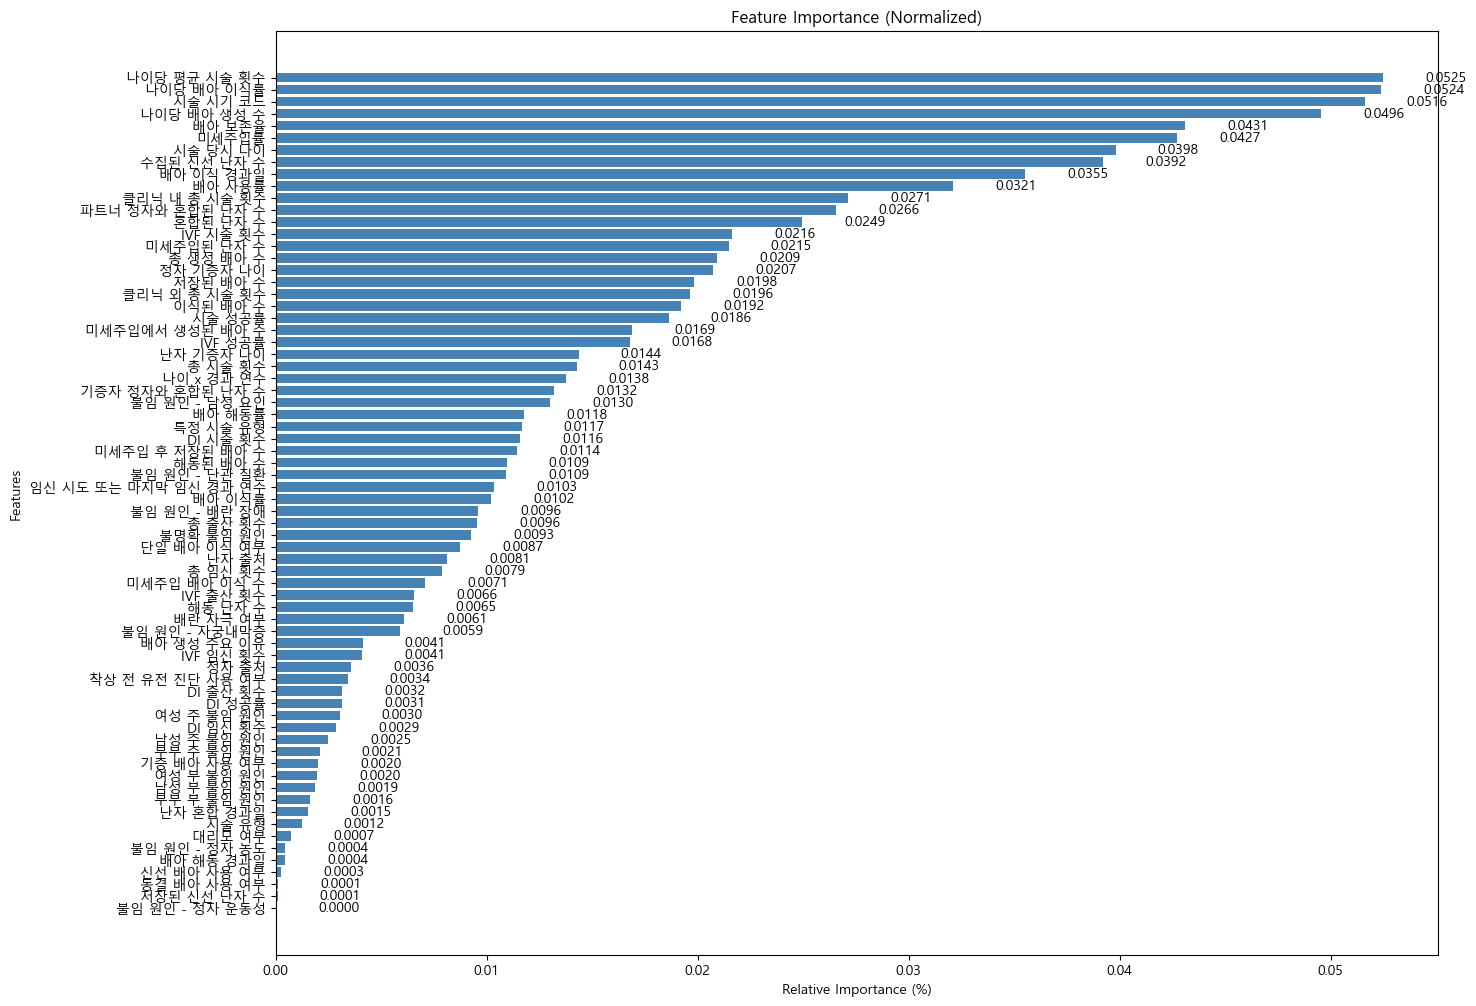

In [371]:
# 6️⃣ Feature Importance 분석
feature_importance_df = feature_importance_df.groupby("Feature").mean().reset_index()
feature_importance_df["Relative Importance"] = feature_importance_df["F Score"] / feature_importance_df["F Score"].sum()
feature_importance_df = feature_importance_df.sort_values(by="Relative Importance", ascending=False)

# 7️⃣ Feature Importance 시각화
plt.figure(figsize=(15, 12))
plt.barh(feature_importance_df["Feature"][:100], feature_importance_df["Relative Importance"][:100], color="steelblue")

# 막대바 옆에 값 표시
for index, value in enumerate(feature_importance_df["Relative Importance"][:100]):
    plt.text(value + 0.002, index, f"{value:.4f}", va='center', fontsize=10)

plt.xlabel("Relative Importance (%)")
plt.ylabel("Features")
plt.title("Feature Importance (Normalized)")
plt.gca().invert_yaxis()  # 상위 Feature를 위로 배치
plt.show()

In [308]:
feature_importance_df['Feature'].tolist()

['시술 시기 코드',
 '시술 당시 나이',
 '나이당 평균 시술 횟수',
 '미세주입률',
 '배아 보존율',
 '배아 사용률',
 '수집된 신선 난자 수',
 '총 생성 배아 수',
 '배아 이식 경과일',
 '클리닉 내 총 시술 횟수',
 '혼합된 난자 수',
 '이식된 배아 수',
 '파트너 정자와 혼합된 난자 수',
 'IVF 시술 횟수',
 '미세주입된 난자 수',
 '클리닉 외 총 시술 횟수',
 '정자 기증자 나이',
 '시술 성공률',
 '저장된 배아 수',
 '미세주입에서 생성된 배아 수',
 'IVF 성공률',
 '총 시술 횟수',
 '불임 원인 - 남성 요인',
 '나이 x 경과 연수',
 '난자 기증자 나이',
 'DI 시술 횟수',
 '기증자 정자와 혼합된 난자 수',
 '미세주입 후 저장된 배아 수',
 '배아 해동률',
 '총 출산 횟수',
 '해동된 배아 수',
 '임신 시도 또는 마지막 임신 경과 연수',
 '특정 시술 유형',
 '단일 배아 이식 여부',
 '배아 이식률',
 '불임 원인 - 난관 질환',
 '불명확 불임 원인',
 '불임 원인 - 배란 장애',
 '해동 난자 수',
 '총 임신 횟수',
 '배란 자극 여부',
 '난자 출처',
 '미세주입 배아 이식 수',
 'IVF 출산 횟수',
 '불임 원인 - 자궁내막증',
 'DI 성공률',
 '배아 생성 주요 이유',
 '시술 유형',
 'DI 출산 횟수',
 'IVF 임신 횟수',
 '정자 출처',
 'DI 임신 횟수',
 '착상 전 유전 진단 사용 여부',
 '여성 주 불임 원인',
 '남성 주 불임 원인',
 '기증 배아 사용 여부',
 '여성 부 불임 원인',
 '난자 혼합 경과일',
 '부부 주 불임 원인',
 '부부 부 불임 원인',
 '남성 부 불임 원인',
 '대리모 여부',
 '배아 해동 경과일',
 '불임 원인 - 정자 농도',
 '저장된 신선 난자 수',
 '동결 배아 사용 여부',
 '불임 원인 - 정자 운동성',
 '신선 배아 사용 여부']

In [ ]:
# 예측
# pred_proba = xgb_model.predict_proba(X_test_encoded)[:, 1]

In [372]:
sample_submission = pd.read_csv('./open/sample_submission.csv')
# sample_submission['probability'] = pred_proba
sample_submission['probability'] = test_preds

In [66]:
sample_submission

,ID,probability
0,TEST_00000,0.001300
1,TEST_00001,0.001735
2,TEST_00002,0.152412
3,TEST_00003,0.105836
4,TEST_00004,0.503041
...,...,...
90062,TEST_90062,0.002571
90063,TEST_90063,0.292727
90064,TEST_90064,0.458203
90065,TEST_90065,0.173277


In [373]:
sample_submission

,ID,probability
0,TEST_00000,0.000940
1,TEST_00001,0.000986
2,TEST_00002,0.146926
3,TEST_00003,0.101157
4,TEST_00004,0.518834
...,...,...
90062,TEST_90062,0.001823
90063,TEST_90063,0.295211
90064,TEST_90064,0.523710
90065,TEST_90065,0.188511


In [374]:
sample_submission.to_csv('./baseline_submit_0226.csv', index=False)